In [3]:
import pandas as pd
import numpy as np
from cherenkovdeconvolution import util
from mord import LogisticAT
from cherenkovdeconvolution import dsea
from sklearn.tree import ExtraTreeClassifier
from matplotlib import pyplot as plt
from sklearn.preprocessing import power_transform
import cherenkovdeconvolution.stepsize as stepsize
from sklearn.ensemble import RandomForestClassifier
df=pd.read_csv('sample.csv', nrows=500000)
X = df[['SplineMPEDirectHitsICE.n_dir_doms',
        'VariousVariables.Cone_Angle',
        'SplineMPECramerRaoParams.variance_theta',
        'Borderness.Q_ratio_in_border',
        'SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value',
        'SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy', 
        'SplineMPEDirectHitsICB.n_late_doms',
        'Dustyness.n_doms_in_dust',
        'LineFitGeoSplit1Params.n_hits',
        'SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness',
        'SPEFit2GeoSplit1BayesianFitParams.logl',
        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom']]
Y = df['MCPrimary.energy']

In [4]:
binning_E = np.logspace(np.log10(Y.min()-10),
np.log10(Y.max()+100), 13)    # creating 12 bins for the energy 
#Binning overflow & underflow manually
#overflow = 1e10
#bins_over = np.append(binning_E,overflow)
#binning_E = bins_over

Y = np.digitize(Y, binning_E)  

Y = Y - 1

bin_1=[i for i in binning_E[:-1]]
bin_2=[i for i in binning_E[1:]]
bin_centers = np.mean([bin_1, bin_2], axis=0)
n_test = int(len(df)/10)

X_train = X.iloc[n_test:]#splitting the dataframe
Y_train = Y[n_test:]

X_test = X.iloc[:n_test]
Y_test = Y[:n_test]

f_true = util.fit_pdf(Y_test) 
f_true


array([2.5592e-01, 3.6756e-01, 2.1952e-01, 9.6880e-02, 3.8640e-02,
       1.4100e-02, 4.6800e-03, 1.6600e-03, 6.8000e-04, 2.4000e-04,
       8.0000e-05, 4.0000e-05])

In [7]:
#logistic AT with decaying stepsize
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul = dsea(X_test, X_train, Y_train, LogisticAT(), K = 7, inspect = inspect_alpha, alpha = alpha_mul)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))

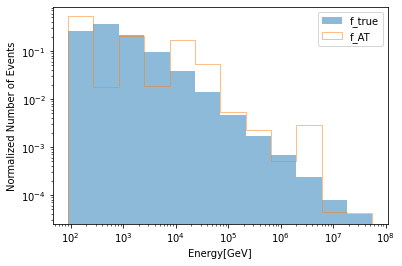

In [3]:
f_AT_mul =([5.23479943e-01, 1.78399880e-02, 2.05062784e-01, 1.83690549e-02,
       1.71428375e-01, 5.26188668e-02, 5.45257357e-03, 2.29334111e-03,
       5.13059360e-04, 2.85618523e-03, 4.32283994e-05, 4.26008326e-05])
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy[GeV]')
plt.ylabel('Normalized Number of Events')
plt.legend(loc='best')
plt.savefig('untransformed_LAT.pdf')

In [5]:
f_AT_mul

array([5.23479943e-01, 1.78399880e-02, 2.05062784e-01, 1.83690549e-02,
       1.71428375e-01, 5.26188668e-02, 5.45257357e-03, 2.29334111e-03,
       5.13059360e-04, 2.85618523e-03, 4.32283994e-05, 4.26008326e-05])

In [7]:
#Yeo-Johnson-Transformation
X_box= power_transform(X, method='yeo-johnson')    
X_btrain = X_box[n_test:]#splitting the dataframe
X_btest = X_box[:n_test]


In [8]:
#logistic AT with decaying stepsize(transformed data)
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul, contr = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 7, inspect = inspect_alpha, alpha = alpha_mul,return_contributions = True)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))

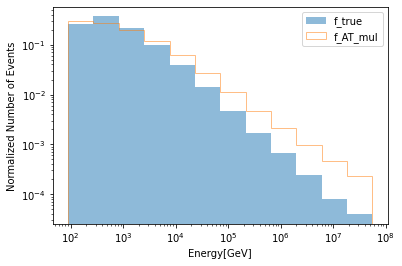

In [4]:
f_AT_mul=([3.02732911e-01, 2.71298607e-01, 1.98476011e-01, 1.19748156e-01,
       6.09226564e-02, 2.70453497e-02, 1.12621793e-02, 4.75032649e-03,
       2.09163987e-03, 9.69053205e-04, 4.70934228e-04, 2.32175901e-04])
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT_mul')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy[GeV]')
plt.ylabel('Normalized Number of Events')
plt.legend(loc='best')
plt.savefig('transformed_LAT.pdf')

In [9]:
f_AT_mul

array([3.02732911e-01, 2.71298607e-01, 1.98476011e-01, 1.19748156e-01,
       6.09226564e-02, 2.70453497e-02, 1.12621793e-02, 4.75032649e-03,
       2.09163987e-03, 9.69053205e-04, 4.70934228e-04, 2.32175901e-04])

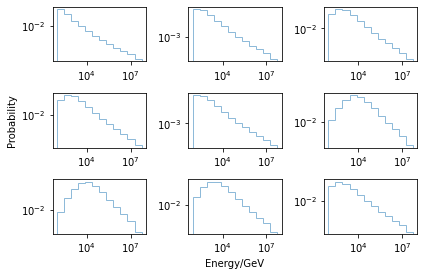

In [6]:
#stepsize selection

In [14]:
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)
    
alpha_exp = stepsize.decay_exp(0.5, 2.0)
f_AT_exp = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 7, inspect = inspect_alpha,  alpha = alpha_exp)

[0.23521018,
 0.23869404,
 0.09848941,
 0.03544797,
 0.01289194,
 0.00452991,
 0.00164207,
 0.05506606,
 0.20868728,
 0.06741491,
 0.02843098,
 0.01349524]

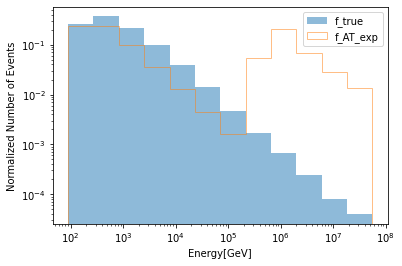

In [5]:
f_AT_exp = ([0.23521018, 0.23869404, 0.09848941, 0.03544797, 0.01289194,
       0.00452991, 0.00164207, 0.05506606, 0.20868728, 0.06741491,
       0.02843098, 0.01349524])
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_AT_exp, alpha = 0.5,histtype = 'step',label='f_AT_exp')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy[GeV]')
plt.ylabel('Normalized Number of Events')
plt.legend(loc='best')
plt.savefig('LAT_exp.pdf')
f_AT_exp

[0.30201219,
 0.2639576,
 0.19094897,
 0.11687106,
 0.06241026,
 0.0305649,
 0.0148694,
 0.00774736,
 0.00445495,
 0.00281654,
 0.00192916,
 0.0014176]

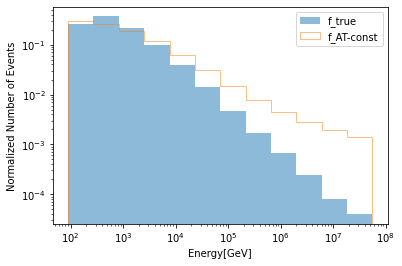

In [6]:
#f_AT_const = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 7, inspect = inspect_alpha,  alpha = 0.5)
f_AT_const = ([0.30201219, 0.2639576 , 0.19094897, 0.11687106, 0.06241026,
       0.0305649 , 0.0148694 , 0.00774736, 0.00445495, 0.00281654,
       0.00192916, 0.0014176 ])
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_AT_const, alpha = 0.5,histtype = 'step',label='f_AT-const')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy[GeV]')
plt.ylabel('Normalized Number of Events')
plt.legend(loc='best')
plt.savefig('LAT_const.pdf')
f_AT_const

In [17]:
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_const, f_true)))
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_exp, f_true)))

Chi square distance between f_est and f_true: 0.10704864103832071
Chi square distance between f_est and f_true: 0.9745812352396451


In [16]:
#testing if iteration number changes results
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 10, inspect = inspect_alpha, alpha = alpha_mul)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))

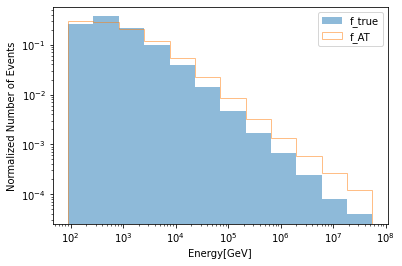

In [7]:
f_AT_mul = ([3.02054497e-01, 2.84016647e-01, 2.06155001e-01, 1.17298054e-01,
       5.46042942e-02, 2.19654845e-02, 8.36555372e-03, 3.25544463e-03,
       1.32545428e-03, 5.72695147e-04, 2.62736563e-04, 1.24136418e-04])
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy[GeV]')
plt.ylabel('Normalized Number of Events')
plt.legend(loc='best')
plt.savefig("logisticAT10it.pdf")

In [17]:
#testing 15 iterations
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 15, inspect = inspect_alpha, alpha = alpha_mul)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))

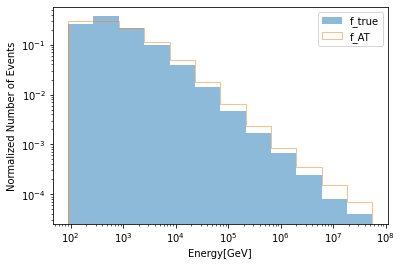

In [8]:
f_AT_mul = ([2.96959482e-01, 2.96779374e-01, 2.14528172e-01, 1.14718422e-01,
       4.88840480e-02, 1.80063917e-02, 6.38040372e-03, 2.30921492e-03,
       8.65744936e-04, 3.47614271e-04, 1.50485267e-04, 7.06476923e-05])
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy[GeV]')
plt.ylabel('Normalized Number of Events')
plt.legend(loc='best')
plt.savefig("logisticAT15it.pdf")

In [19]:
#testing 20 iterations
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 20, inspect = inspect_alpha, alpha = alpha_mul)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))

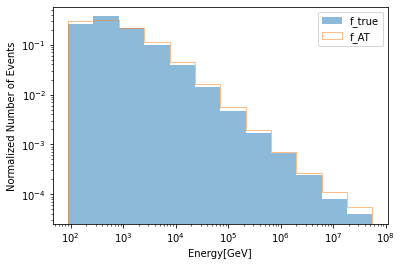

In [9]:
f_AT_mul = ([2.91851945e-01, 3.04844898e-01, 2.19959889e-01, 1.12921670e-01,
       4.56819632e-02, 1.61202433e-02, 5.55424703e-03, 1.93899828e-03,
       6.90545994e-04, 2.66310810e-04, 1.12966882e-04, 5.63230722e-05])
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy[GeV]')
plt.ylabel('Normalized Number of Events')
plt.legend(loc='best')
plt.savefig("logisticAT20it.pdf")

In [8]:
#testing even more iterations(30)
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul, contr = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 30, inspect = inspect_alpha, alpha = alpha_mul, return_contributions = True)
f_AT_mul

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


array([2.84134527e-01, 3.14991506e-01, 2.26472064e-01, 1.10276381e-01,
       4.21792677e-02, 1.44224257e-02, 4.93589048e-03, 1.67341218e-03,
       5.60406534e-04, 2.08508722e-04, 9.06780825e-05, 5.49326398e-05])

Chi square distance between f_est and f_true: 0.013359360577625682


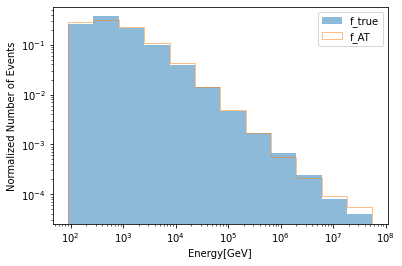

In [9]:
#f_AT_mul =[2.84134527e-01, 3.14991506e-01, 2.26472064e-01, 1.10276381e-01,
#       4.21792677e-02, 1.44224257e-02, 4.93589048e-03, 1.67341218e-03,
#       5.60406534e-04, 2.08508722e-04, 9.06780825e-05, 5.49326398e-05]
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy[GeV]')
plt.ylabel('Normalized Number of Events')
plt.legend(loc='best')
plt.savefig("logisticAT30it.pdf")

In [10]:
#Random Forrest with transformed data(30 iterations)
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_RF_mul, contr_rf = dsea(X_btest, X_btrain, Y_train, RandomForestClassifier(), K = 30, inspect = inspect_alpha, alpha = alpha_mul, return_contributions = True)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


Chi square distance between f_est and f_true: 0.00045722006022999476


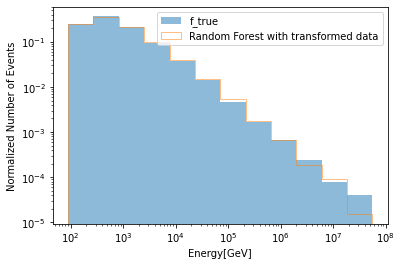

In [11]:
#f_RF_mul=[2.51935417e-01, 3.65409209e-01, 2.19064617e-01, 1.00211902e-01,
#       4.03958012e-02, 1.47860358e-02, 5.43439568e-03, 1.78624042e-03,
#       6.85137401e-04, 1.84547894e-04, 9.16101038e-05, 1.50866480e-05]
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_RF_mul, f_true)))
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_RF_mul, alpha = 0.5,histtype = 'step',label='Random Forest with transformed data')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy[GeV]')
plt.ylabel('Normalized Number of Events')
plt.legend(loc='best')
plt.savefig("rf30.pdf")


In [12]:
def rate_contr(contr):
    rating=0
    indices=[]
    contr_1st=contr.argsort()[:,-1]#returns indices of the highest value
    contr_2nd=contr.argsort()[:,-2]#return indices of the 2nd highest value
    
    contr_gap=contr_1st-contr_2nd#array of distances between the highest and 2nd highest bin
    for i in range(len(contr)):
        if contr_gap[i]>2:
            rating=rating+1
            indices.append(i)
        elif contr_gap[i]<(-2):
            rating=rating+1
            indices.append(i)
            
    return rating, indices   


In [13]:
x_3,y_3=rate_contr(contr_rf)
x_3

12

In [2]:
fig, axs = plt.subplots(3, 3)


axs[0,0].hist(bin_centers, bins = binning_E, weights = contr[1], alpha = 0.5, histtype = 'step')
#axs[0,0].set_title('Bin# of MC-truth'.format(Y[1]))
#axs[0,0].gca().set_xscale('log')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
#axs[0,0].set_xlabel('Energy/GeV')
axs[1,0].hist(bin_centers, bins = binning_E, weights = contr[2], alpha = 0.5, histtype = 'step', label= 'Event Number:2')
#axs[1,0].set_title('Bin# of MC-truth'.format(Y[2]))
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel('Probability')

axs[0,1].hist(bin_centers, bins = binning_E, weights = contr[3], alpha = 0.5, histtype = 'step', label= 'Event Number:3')
#axs[0,1].set_title('Bin# of MC-truth'.format(Y[3]))
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
#axs[0,1].set_xlabel('Energy/GeV')

axs[0,2].hist(bin_centers, bins = binning_E, weights = contr[4], alpha = 0.5, histtype = 'step', label= 'Event Number:4')
#axs[0,2].set_title('Bin# of MC-truth'.format(Y[4]))
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')

axs[1,1].hist(bin_centers, bins = binning_E, weights = contr[5], alpha = 0.5, histtype = 'step', label= 'Event Number:5')
#axs[1,1].set_title('Bin# of MC-truth'.format(Y[5])
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
#axs[1,1].set_xlabel('Energy/GeV')
axs[2,1].hist(bin_centers, bins = binning_E, weights = contr[6], alpha = 0.5, histtype = 'step', label= 'Event Number:6')
#axs[2,1].set_title('Bin# of MC-truth'.format(Y[6]))
axs[2,1].set_xscale('log')
axs[2,1].set_yscale('log')
axs[2,1].set_xlabel('Energy/GeV')
axs[2,0].hist(bin_centers, bins = binning_E, weights = contr[7], alpha = 0.5, histtype = 'step', label= 'Event Number:7')
#axs[2,0].set_title('Bin# of MC-truth'.format(Y[7]))
axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')

axs[1,2].hist(bin_centers, bins = binning_E, weights = contr[8], alpha = 0.5, histtype = 'step', label= 'Event Number:8')
#axs[1,2].set_title('Bin# of MC-truth'.format(Y[8]))
axs[1,2].set_xscale('log')
axs[1,2].set_yscale('log')

axs[2,2].hist(bin_centers, bins = binning_E, weights = contr[9], alpha = 0.5, histtype = 'step', label= '#9')
#axs[2,2].set_title('Bin# of MC-truth'.format(Y[9]))
axs[2,2].set_xscale('log')
axs[2,2].set_yscale('log')


fig.tight_layout()
plt.savefig("cor_ord.pdf")

NameError: name 'plt' is not defined

[0.   0.29 0.23 0.23 0.23 0.01 0.01 0.   0.   0.   0.   0.  ]
[9.00004723e+01 2.73590298e+02 8.31680647e+02 2.52820624e+03
 7.68543410e+03 2.33627685e+04 7.10199251e+04 2.15891783e+05
 6.56284303e+05 1.99502306e+06 6.06462322e+06 1.84357041e+07
 5.60422588e+07]


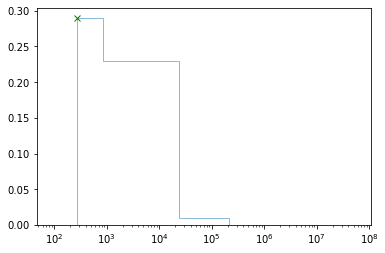

In [51]:
n,bins, patches=plt.hist(bin_centers, bins = binning_E, weights = contr_rf[y_3[5]], alpha = 0.5, histtype = 'step')
plt.plot(binning_E[Y[y_3[5]]],contr_rf[y_3[5]][Y[y_3[5]]],'gx',label='MC-truth')
plt.gca().set_xscale('log')

print(n)
print(bins)
print(patches)

In [44]:
contr_rf[y_3[5]][Y[y_3[5]]]

0.29

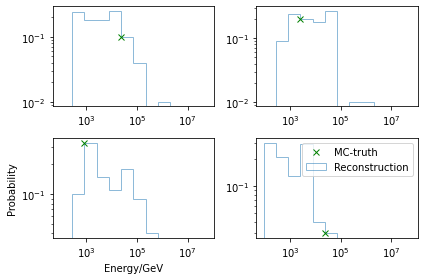

In [60]:
fig, axs = plt.subplots(2, 2)


axs[0,0].hist(bin_centers, bins = binning_E, weights = contr_rf[y_3[8]], alpha = 0.5, histtype = 'step',label='Reconstruction')
axs[0,0].plot(binning_E[Y[y_3[8]]],contr_rf[y_3[8]][Y[y_3[8]]],'gx',label='MC-truth')
#axs[0,0].legend(loc="best")
#axs[0,0].set_title(Y[1])
#axs[0,0].gca().set_xscale('log')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
#axs[0,0].set_xlabel('Energy/GeV')

axs[1,0].hist(bin_centers, bins = binning_E, weights = contr_rf[y_3[6]], alpha = 0.5, histtype = 'step',label='Reconstruction')
axs[1,0].plot(binning_E[Y[y_3[6]]],contr_rf[y_3[6]][Y[y_3[6]]],'gx',label='MC-truth')
#axs[1,0].legend(loc="best")
#axs[1,0].set_title(Y[y_3[1]])
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel('Probability')
axs[1,0].set_xlabel('Energy/GeV')

axs[0,1].hist(bin_centers, bins = binning_E, weights = contr_rf[y_3[9]], alpha = 0.5, histtype = 'step',label='Reconstruction')
axs[0,1].plot(binning_E[Y[y_3[9]]],contr_rf[y_3[9]][Y[y_3[9]]],'gx',label='MC-truth')
#axs[0,1].legend(loc="best")
#axs[0,1].set_title(Y[y_3[2]])
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
#axs[0,1].set_xlabel('Energy/GeV')



axs[1,1].hist(bin_centers, bins = binning_E, weights = contr_rf[y_3[4]], alpha = 0.5, histtype = 'step',label='Reconstruction')
axs[1,1].plot(binning_E[Y[y_3[4]]],contr_rf[y_3[4]][Y[y_3[4]]],'gx',label='MC-truth')
axs[1,1].legend(loc="best")
#axs[1,1].set_title(Y[y_3[4]]) 
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
#axs[1,1].set_xlabel('Energy/GeV')


fig.tight_layout()
plt.savefig("contr_nom.pdf")

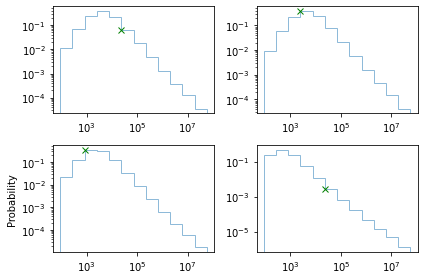

In [62]:
fig, axs = plt.subplots(2, 2)


axs[0,0].hist(bin_centers, bins = binning_E, weights = contr[y_3[8]], alpha = 0.5, histtype = 'step')
axs[0,0].plot(binning_E[Y[y_3[8]]],contr[y_3[8]][Y[y_3[8]]],'gx',label='MC-truth')
#axs[0,0].set_title('Bin# of MC-truth'.format(Y[1]))
#axs[0,0].gca().set_xscale('log')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
#axs[0,0].set_xlabel('Energy/GeV')
axs[1,0].hist(bin_centers, bins = binning_E, weights = contr[y_3[6]], alpha = 0.5, histtype = 'step')
axs[1,0].plot(binning_E[Y[y_3[6]]],contr[y_3[6]][Y[y_3[6]]],'gx',label='MC-truth')
#axs[1,0].set_title('Bin# of MC-truth'.format(Y[2]))
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel('Probability')

axs[0,1].hist(bin_centers, bins = binning_E, weights = contr[y_3[9]], alpha = 0.5, histtype = 'step',label='Reconstruction')
axs[0,1].plot(binning_E[Y[y_3[9]]],contr[y_3[9]][Y[y_3[9]]],'gx',label='MC-truth')
#axs[0,1].legend(loc="best")
#axs[0,1].set_title('Bin# of MC-truth'.format(Y[3]))
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
#axs[0,1].set_xlabel('Energy/GeV')



axs[1,1].hist(bin_centers, bins = binning_E, weights = contr[y_3[4]], alpha = 0.5, histtype = 'step')
axs[1,1].plot(binning_E[Y[y_3[4]]],contr[y_3[4]][Y[y_3[4]]],'gx',label='MC-truth')
#axs[1,1].set_title('Bin# of MC-truth'.format(Y[5])
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
#axs[1,1].set_xlabel('Energy/GeV')


fig.tight_layout()
plt.savefig("cor_ord.pdf")

Text(0.5, 0, 'Energy/GeV')

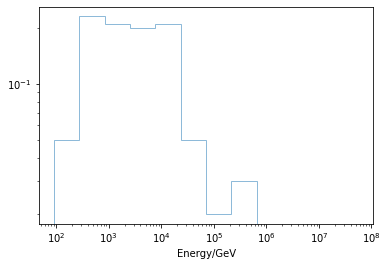

In [10]:
plt.hist(bin_centers, bins = binning_E, weights = contr_rf[y_3[1]], alpha = 0.5, histtype = 'step')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')

0
1
2
3
Chi square distance between f_est and f_true: 0.00042049799775270254


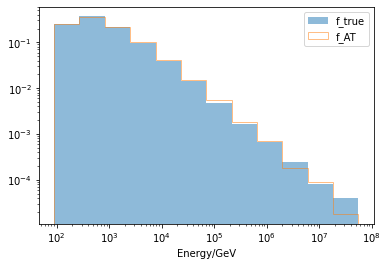

In [4]:
#Random Forrest with transformed data
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_RF_mul = dsea(X_btest, X_btrain, Y_train, RandomForestClassifier(), K = 30, inspect = inspect_alpha, alpha = alpha_mul)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='Randomforrest with transformed data')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')
plt.legend(loc='best')
plt.show()

In [12]:
#trying a regression(without y-j-transormation)
from sklearn.linear_model import Ridge
y = df['MCPrimary.energy'] #reading target 
y_train=y[n_test:]   #test-trainsplit for unbinned target

f_reg=Ridge().fit(X_train,y_train)#fitting regression
f_pred=f_reg.predict(X_test)#testing prediction
f_pred = np.digitize(f_pred, binning_E)
#np.unique(f_pred)
f_pred = util.fit_pdf(f_pred)
f_pred

array([4.6576e-01, 1.0580e-02, 3.1700e-02, 8.7700e-02, 1.7720e-01,
       1.5532e-01, 5.7620e-02, 1.1700e-02, 1.9400e-03, 3.2000e-04,
       1.2000e-04, 4.0000e-05])

In [10]:
#I only get 11 results; should be 12
#that could mean that the 12th bin is empty?
f_pred = np.append(f_pred,0)#adding 12 bin manually
f_pred

array([4.6576e-01, 1.0580e-02, 3.1700e-02, 8.7700e-02, 1.7720e-01,
       1.5532e-01, 5.7620e-02, 1.1700e-02, 1.9400e-03, 3.2000e-04,
       1.2000e-04, 4.0000e-05, 0.0000e+00])

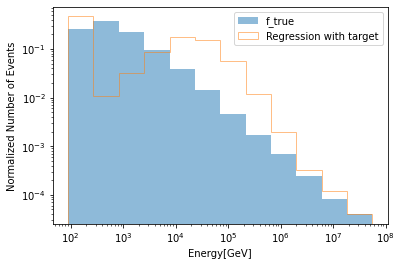

In [13]:
f_pred=([4.6576e-01, 1.0580e-02, 3.1700e-02, 8.7700e-02, 1.7720e-01,
       1.5532e-01, 5.7620e-02, 1.1700e-02, 1.9400e-03, 3.2000e-04,
       1.2000e-04, 4.0000e-05])
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_pred, alpha = 0.5,histtype = 'step',label='Regression with target')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy[GeV]')
plt.ylabel('Normalized Number of Events')
plt.legend(loc='best')
plt.savefig("ridge_ut.pdf")

In [14]:
#regression with binned data
f_reg2=Ridge().fit(X_train,Y_train)#fitting regression
f_pred2=f_reg2.predict(X_test)#testing prediction
binning_pred=np.linspace(1,11,11)#I don't know if that is right but because np.digitize is open to the left and closed to the right it 
f_pred2=np.digitize(f_pred2,binning_pred)#should put the underflow into bin 0 and stops at 11 as the true pdf does
f_pred2=util.fit_pdf(f_pred2)
f_pred2

array([3.3292e-01, 5.1084e-01, 1.2852e-01, 1.8160e-02, 4.8200e-03,
       2.2200e-03, 1.0600e-03, 6.0000e-04, 3.8000e-04, 2.4000e-04,
       1.0000e-04, 1.4000e-04])

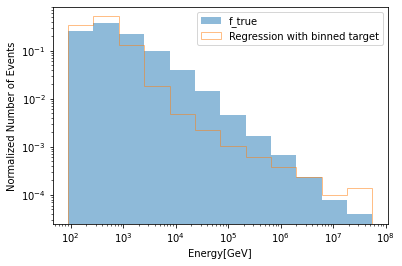

In [14]:
f_pred2 =([3.3292e-01, 5.1084e-01, 1.2852e-01, 1.8160e-02, 4.8200e-03,
       2.2200e-03, 1.0600e-03, 6.0000e-04, 3.8000e-04, 2.4000e-04,
       1.0000e-04, 1.4000e-04])
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_pred2, alpha = 0.5,histtype = 'step',label='Regression with binned target')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy[GeV]')
plt.ylabel('Normalized Number of Events')
plt.legend(loc='best')
plt.savefig("ridge_binned.pdf")

In [16]:
print('Chi square distance between Ridge-regression with unbinned target and f_true: {}'.format(util.chi2s(f_pred, f_true)))
print('Chi square distance between Ridge-regression with binned target and f_true: {}'.format(util.chi2s(f_pred2, f_true)))

Chi square distance between Ridge-regression with unbinned target and f_true: 1.5974305141579754
Chi square distance between Ridge-regression with binned target and f_true: 0.29797831282696047


Chi square distance between BayesianRidge-regression with binned target and f_true: 0.2985989363013696


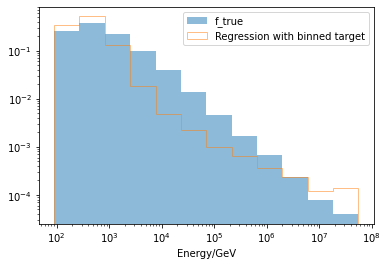

In [8]:
#trying bayesian ridge regression
from sklearn.linear_model import BayesianRidge
f_reg3=BayesianRidge().fit(X_train,Y_train)#fitting regression
f_pred3=f_reg3.predict(X_test)#testing prediction
binning_pred=np.linspace(1,11,11)#I don't know if that is right but because np.digitize is open to the left and closed to the right it 
f_pred3=np.digitize(f_pred3,binning_pred)#should put the underflow into bin 0 and stops at 11 as the true pdf does
f_pred3=util.fit_pdf(f_pred3)
print('Chi square distance between BayesianRidge-regression with binned target and f_true: {}'.format(util.chi2s(f_pred3, f_true)))
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_pred3, alpha = 0.5,histtype = 'step',label='Regression with binned target')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')
plt.legend(loc='best')
plt.show()

In [27]:
#trying out Tim Ruhes advice
Y = df['MCPrimary.energy']
binning_E = np.logspace(np.log10(Y.min()-10),# creating 12 bins for the energy 
np.log10(1e5), 13)    #limiting my energy to 1e5 GeV
#Binning overflow & underflow manually
overflow = 1e9
bins_over = np.append(binning_E,overflow)
binning_E = bins_over

Y = np.digitize(Y, binning_E)  

Y = Y - 1

bin_1=[i for i in binning_E[:-1]]
bin_2=[i for i in binning_E[1:]]
bin_centers = np.mean([bin_1, bin_2], axis=0)
#n_test = int(len(df)/10)


Y_train = Y[n_test:]


Y_test = Y[:n_test]

f_true = util.fit_pdf(Y_test) 
f_true


array([0.08536, 0.1916 , 0.20522, 0.17122, 0.12734, 0.0837 , 0.05384,
       0.03258, 0.02042, 0.01236, 0.0068 , 0.00434, 0.00522])

0
1
2
3
Chi square distance between f_est and f_true: 0.16351851376069956


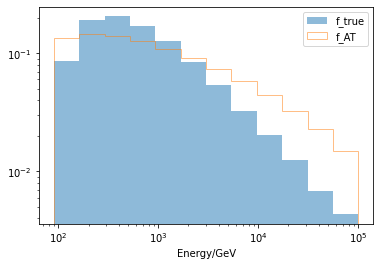

In [6]:
#logistic AT with decaying stepsize(transformed data+limit to 1e5 GeV)
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 3, inspect = inspect_alpha, alpha = alpha_mul)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')
plt.legend(loc='best')
plt.show()

In [28]:
#logistic AT with decaying stepsize(transformed data+limit to 1e5 GeV+more iteration steps)
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 20, inspect = inspect_alpha, alpha = alpha_mul)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Chi square distance between f_est and f_true: 0.0201865469885582


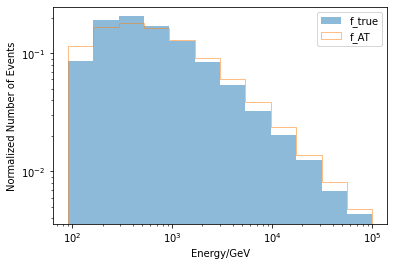

In [29]:

plt.hist(bin_centers, bins = binning_E[0:13], weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')
plt.ylabel('Normalized Number of Events')
plt.legend(loc='best')
plt.savefig("logisticAT20itUT.pdf")

In [30]:
#testing even more iterations(30)
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul, contr_AT = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 30, inspect = inspect_alpha, alpha = alpha_mul, return_contributions = True)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))
f_AT_mul

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
Chi square distance between f_est and f_true: 0.01248945953742212


array([0.10886088, 0.1680706 , 0.18816715, 0.16944693, 0.13021582,
       0.09021991, 0.05856581, 0.03632342, 0.02173771, 0.01271253,
       0.00749548, 0.00468857, 0.00349519])

ValueError: weights should have the same shape as x

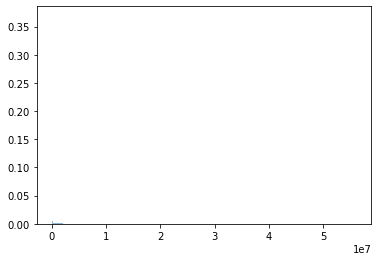

In [15]:
f_AT_mul=([0.10886088, 0.1680706 , 0.18816715, 0.16944693, 0.13021582,
       0.09021991, 0.05856581, 0.03632342, 0.02173771, 0.01271253,
       0.00749548, 0.00468857, 0.00349519])
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy[GeV]')
plt.ylabel('Normalized Number of Events')
plt.legend(loc='best')
plt.savefig("logisticAT30itUT.pdf")

Chi square distance between f_est and f_true: 0.0003670241250109776


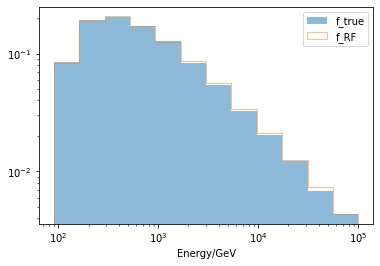

In [8]:
#Random Forrest for comperision(without tranfromed data+limited energy range)
f_est= dsea(X_test, X_train, Y_train,RandomForestClassifier(), K=3)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_est, f_true)))
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers,  bins = binning_E[0:13], weights = f_est, alpha = 0.5,histtype = 'step',label='f_RF')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')
plt.legend(loc='best')
plt.show()

In [18]:
#Random Forrest with transformed data+limited energy
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_RF_mul, contr_RF = dsea(X_btest, X_btrain, Y_train, RandomForestClassifier(), K = 30, inspect = inspect_alpha, alpha = alpha_mul,return_contributions = True)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')
plt.legend(loc='best')
plt.show()

0


KeyboardInterrupt: 

In [ ]:
f_RF_mul

In [14]:
#limiting the energy further to 1e4 GeV
#mathis did that in his master thesis
Y = df['MCPrimary.energy']
binning_E = np.logspace(np.log10(Y.min()-10),# creating 12 bins for the energy 
np.log10(1e4), 13)    #limiting my energy to 1e5 GeV
#Binning overflow & underflow manually
overflow = 1e9
bins_over = np.append(binning_E,overflow)
binning_E = bins_over

Y = np.digitize(Y, binning_E)  

Y = Y - 1

bin_1=[i for i in binning_E[:-1]]
bin_2=[i for i in binning_E[1:]]
bin_centers = np.mean([bin_1, bin_2], axis=0)
#n_test = int(len(df)/10)


Y_train = Y[n_test:]


Y_test = Y[:n_test]

f_true = util.fit_pdf(Y_test) 
f_true


array([0.04078, 0.1021 , 0.13716, 0.1402 , 0.12874, 0.10904, 0.0886 ,
       0.06858, 0.05218, 0.03878, 0.02664, 0.0196 , 0.0476 ])

In [15]:
#logistic AT with decaying stepsize(transformed data)
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 3, inspect = inspect_alpha, alpha = alpha_mul)

In [17]:
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))

Chi square distance between f_est and f_true: 0.12625950965379784


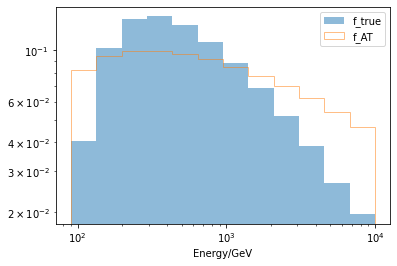

In [16]:
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')
plt.legend(loc='best')
plt.show()

0
1
2
3
4
5
6
7
8
9
10
Chi square distance between f_est and f_true: 0.0654393329080982


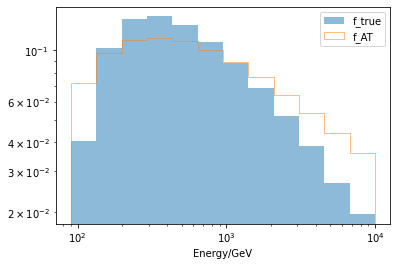

In [18]:
#logistic AT with decaying stepsize+more iterations(transformed data)
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 10, inspect = inspect_alpha, alpha = alpha_mul)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E[0:13], weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')
plt.legend(loc='best')
plt.show()

In [3]:
#running the full set
df=pd.read_csv('sample.csv')
X = df[['SplineMPEDirectHitsICE.n_dir_doms',
        'VariousVariables.Cone_Angle',
        'SplineMPECramerRaoParams.variance_theta',
        'Borderness.Q_ratio_in_border',
        'SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value',
        #'SplineMPETruncatesEnergy_SPICEMie_DOMS_Neutrino.energy', That feature is not in my MC
        'SplineMPEDirectHitsICB.n_late_doms',
        'Dustyness.n_doms_in_dust',
        'LineFitGeoSplit1Params.n_hits',
        'SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness',
        'SPEFit2GeoSplit1BayesianFitParams.logl',
        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom']]
Y = df['MCPrimary.energy']

In [4]:
binning_E = np.logspace(np.log10(Y.min()-10),
np.log10(Y.max()+100), 13)    # creating 12 bins for the energy 
#Binning overflow & underflow manually
#overflow = 1e10
#bins_over = np.append(binning_E,overflow)
#binning_E = bins_over

Y = np.digitize(Y, binning_E)  

Y = Y - 1

bin_1=[i for i in binning_E[:-1]]
bin_2=[i for i in binning_E[1:]]
bin_centers = np.mean([bin_1, bin_2], axis=0)
n_test = int(len(df)/10)

X_train = X.iloc[n_test:]#splitting the dataframe
Y_train = Y[n_test:]

X_test = X.iloc[:n_test]
Y_test = Y[:n_test]

f_true = util.fit_pdf(Y_test) 
f_true

array([2.71180035e-01, 3.79863201e-01, 2.10853320e-01, 8.76662183e-02,
       3.29302254e-02, 1.16365910e-02, 3.92835237e-03, 1.30920085e-03,
       4.31151482e-04, 1.50715561e-04, 3.59917759e-05, 1.49965733e-05])

In [5]:
#Yeo-Johnson-Transformation
X_box= power_transform(X, method='yeo-johnson')    
X_btrain = X_box[n_test:]#splitting the dataframe
X_btest = X_box[:n_test]


0
1
3


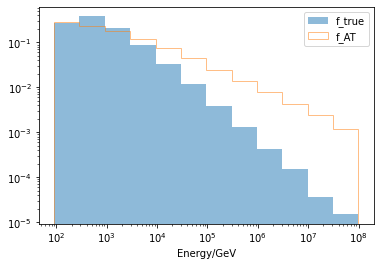

In [6]:
#logistic AT with decaying stepsize(transformed data)
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul,contr = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 3, inspect = inspect_alpha, alpha = alpha_mul,return_contributions = True)
plt.hist(bin_centers, bins = binning_E, weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(bin_centers, bins = binning_E, weights = f_AT_mul, alpha = 0.5,histtype = 'step',label='f_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy/GeV')
plt.legend(loc='best')
plt.show()

In [7]:
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_AT_mul, f_true)))

Chi square distance between f_est and f_true: 0.23316544574310885


In [6]:
#calculating the wasserstein distance
from scipy.stats import wasserstein_distance
#saving the pdf's in variables
f_true=([2.5592e-01, 3.6756e-01, 2.1952e-01, 9.6880e-02, 3.8640e-02,
       1.4100e-02, 4.6800e-03, 1.6600e-03, 6.8000e-04, 2.4000e-04,
       8.0000e-05, 4.0000e-05])
f_ut=([5.23479943e-01, 1.78399880e-02, 2.05062784e-01, 1.83690549e-02,
       1.71428375e-01, 5.26188668e-02, 5.45257357e-03, 2.29334111e-03,
       5.13059360e-04, 2.85618523e-03, 4.32283994e-05, 4.26008326e-05])
f_trafo=([3.02732911e-01, 2.71298607e-01, 1.98476011e-01, 1.19748156e-01,
       6.09226564e-02, 2.70453497e-02, 1.12621793e-02, 4.75032649e-03,
       2.09163987e-03, 9.69053205e-04, 4.70934228e-04, 2.32175901e-04])
f_exp=[0.23521018, 0.23869404, 0.09848941, 0.03544797, 0.01289194,
       0.00452991, 0.00164207, 0.05506606, 0.20868728, 0.06741491,
       0.02843098, 0.01349524]
f_const= [0.30201219, 0.2639576 , 0.19094897, 0.11687106, 0.06241026,
       0.0305649 , 0.0148694 , 0.00774736, 0.00445495, 0.00281654,
       0.00192916, 0.0014176 ]
f_at_mul_10=[3.02054497e-01, 2.84016647e-01, 2.06155001e-01, 1.17298054e-01,
       5.46042942e-02, 2.19654845e-02, 8.36555372e-03, 3.25544463e-03,
       1.32545428e-03, 5.72695147e-04, 2.62736563e-04, 1.24136418e-04]
f_at_mul_15=[2.96959482e-01, 2.96779374e-01, 2.14528172e-01, 1.14718422e-01,
       4.88840480e-02, 1.80063917e-02, 6.38040372e-03, 2.30921492e-03,
       8.65744936e-04, 3.47614271e-04, 1.50485267e-04, 7.06476923e-05]
f_at_mul_20= [2.91851945e-01, 3.04844898e-01, 2.19959889e-01, 1.12921670e-01,
       4.56819632e-02, 1.61202433e-02, 5.55424703e-03, 1.93899828e-03,
       6.90545994e-04, 2.66310810e-04, 1.12966882e-04, 5.63230722e-05]
f_at_mul_30=[2.84134527e-01, 3.14991506e-01, 2.26472064e-01, 1.10276381e-01,
       4.21792677e-02, 1.44224257e-02, 4.93589048e-03, 1.67341218e-03,
       5.60406534e-04, 2.08508722e-04, 9.06780825e-05, 5.49326398e-05]
f_rf_mul_30=[2.51935417e-01, 3.65409209e-01, 2.19064617e-01, 1.00211902e-01,
       4.03958012e-02, 1.47860358e-02, 5.43439568e-03, 1.78624042e-03,
       6.85137401e-04, 1.84547894e-04, 9.16101038e-05, 1.50866480e-05]
f_limited_20=[2.91851945e-01, 3.04844898e-01, 2.19959889e-01, 1.12921670e-01,
       4.56819632e-02, 1.61202433e-02, 5.55424703e-03, 1.93899828e-03,
       6.90545994e-04, 2.66310810e-04, 1.12966882e-04, 5.63230722e-05]
f_limited_30=([0.10886088, 0.1680706 , 0.18816715, 0.16944693, 0.13021582,
       0.09021991, 0.05856581, 0.03632342, 0.02173771, 0.01271253,
       0.00749548, 0.00468857, 0.00349519])

In [26]:
print('Wasserstein distance between f_ut and f_true: {}'.format(wasserstein_distance(f_ut, f_true)))
print('Wasserstein distance between f_trafo and f_true: {}'.format(wasserstein_distance(f_trafo, f_true)))
print('Wasserstein distance between f_exp and f_true: {}'.format(wasserstein_distance(f_exp, f_true)))
print('Wasserstein distance between f_const and f_true: {}'.format(wasserstein_distance(f_const, f_true)))
print('Wasserstein distance between f_at_mul_10 and f_true: {}'.format(wasserstein_distance(f_at_mul_10, f_true)))
print('Wasserstein distance between f_at_mul_15 and f_true: {}'.format(wasserstein_distance(f_at_mul_15, f_true)))
print('Wasserstein distance between f_at_mul_20 and f_true: {}'.format(wasserstein_distance(f_at_mul_20, f_true)))
print('Wasserstein distance between f_at_mul_30 and f_true: {}'.format(wasserstein_distance(f_at_mul_30, f_true)))
print('Wasserstein distance between f_rf_mul_30 and f_true: {}'.format(wasserstein_distance(f_rf_mul_30, f_true)))
print('Wasserstein distance between f_limited_20 and f_true: {}'.format(wasserstein_distance(f_limited_20, f_true)))
print('Wasserstein distance between f_limited_30 and f_true: {}'.format(wasserstein_distance(f_limited_30, f_true)))

Wasserstein distance between f_ut and f_true: 0.027252948500266667
Wasserstein distance between f_trafo and f_true: 0.014311846341166671
Wasserstein distance between f_exp and f_true: 0.02673474916666667
Wasserstein distance between f_const and f_true: 0.015686472500000003
Wasserstein distance between f_at_mul_10 and f_true: 0.013145083538166671
Wasserstein distance between f_at_mul_15 and f_true: 0.012598724375525
Wasserstein distance between f_at_mul_20 and f_true: 0.010452517047350004
Wasserstein distance between f_at_mul_30 and f_true: 0.008786596460525008
Wasserstein distance between f_rf_mul_30 and f_true: 0.0011118537552333317
Wasserstein distance between f_limited_20 and f_true: 0.010452517047350004
Wasserstein distance between f_limited_30 and f_true: 0.048206876666666676


In [8]:
events_true = [i * 500000 for i in f_true]
print(events_true)
events_at30 = [i * 500000 for i in f_at_mul_30]
print(events_at30)

[127959.99999999999, 183780.0, 109760.0, 48440.0, 19320.0, 7050.0, 2340.0, 830.0, 340.0, 120.0, 40.0, 20.0]
[142067.2635, 157495.753, 113236.032, 55138.190500000004, 21089.633850000002, 7211.21285, 2467.94524, 836.7060899999999, 280.203267, 104.254361, 45.33904125, 27.466319900000002]


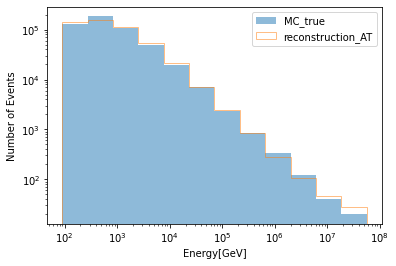

In [9]:
plt.hist(bin_centers, bins = binning_E, weights = events_true, alpha = 0.5,label ='MC_true')
plt.hist(bin_centers, bins = binning_E, weights = events_at30, alpha = 0.5,histtype = 'step',label='reconstruction_AT')
plt.gca().set_xscale('log')
plt.yscale('log')
plt.xlabel('Energy[GeV]')
plt.ylabel('Number of Events')
plt.legend(loc='best')
plt.savefig("EventsAT30it.pdf")

In [10]:
events_limited_30 = [i * 500000 for i in f_limited_30]
print(events_limited_30)

[54430.439999999995, 84035.29999999999, 94083.575, 84723.465, 65107.91, 45109.955, 29282.905000000002, 18161.710000000003, 10868.855, 6356.264999999999, 3747.74, 2344.2850000000003, 1747.595]
